# Train a custom object (category) in 30 minutes

In [1]:
import numpy as np
import pyrender
import OpenGL
OpenGL.FULL_LOGGING = False
OpenGL.ERROR_LOGGING = False
from pyrender import IntrinsicsCamera,\
                DirectionalLight, SpotLight, Mesh, Scene,\
                OffscreenRenderer, RenderFlags
import logging
logger = logging.getLogger("OpenGL.arrays.arraydatatype")
logger.setLevel(logging.ERROR)
logger = logging.getLogger('OpenGL.acceleratesupport')
logger.setLevel(logging.ERROR)
from pathlib import Path
import os
os.environ.update(
    PYOPENGL_PLATFORM = 'egl',
    PYOPENGL_FULL_LOGGING = '0'
)
import cv2
import torch
import trimesh
from scipy.stats import special_ortho_group
from omegaconf import OmegaConf
import sys
sys.path.append(str('../'))
import pickle
from src_shot.build import shot
from utils.util import backproject, downsample
from dataset import DINOV2, resize_crop
from tqdm.notebook import tqdm
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [4]:
cfg = OmegaConf.load('config/custom.yaml')
intrinsics = np.array([[591.0125, 0, 320], [0, 590.16775, 240], [0, 0, 1]])

## First, dump training data.
Here only a single mesh from YCBV dataset is used as an example. You may want to randomize the mesh within your category for each iteration.

In [7]:
r = OffscreenRenderer(viewport_width=640, viewport_height=480)
# You can replace the mesh with your own category's meshes, and randomly sample one during each iteration
mesh = trimesh.load('example_data/obj_000015.ply')
mesh.apply_scale(0.001)  # convert mm to m
bounds = mesh.bounds
trans_mat = np.eye(4)
trans_mat[:3, -1] = -(bounds[1] + bounds[0]) / 2  # center the mesh
mesh.apply_transform(trans_mat)

with torch.no_grad():
    desc_model = DINOV2().eval().cuda()
    for i in tqdm(range(1000)):
        mesh_pose = np.eye(4)
        mesh_pose[:3, :3] = special_ortho_group.rvs(3)
        tr = np.array([np.random.uniform(-0.3, 0.3), np.random.uniform(-0.3, 0.3), -np.random.uniform(0.6, 2.0)])
        mesh_pose[:3, -1] = tr
        mesh.apply_transform(mesh_pose)
        if isinstance(mesh, trimesh.Scene):
            scene = Scene.from_trimesh_scene(mesh)
            scene.bg_color = np.zeros((3,))
        else:
            scene = Scene(ambient_light=np.array([0.02, 0.02, 0.02, 1.0]), bg_color=np.zeros((3,)))
            scene.add(Mesh.from_trimesh(mesh), pose=np.eye(4))

        cam_pose = np.eye(4)
        cam = IntrinsicsCamera(intrinsics[0, 0], intrinsics[1, 1], intrinsics[0, 2], intrinsics[1, 2])
                
        direc_l = DirectionalLight(color=np.ones(3), intensity=np.random.uniform(5, 15))
        spot_l = SpotLight(color=np.ones(3), intensity=np.random.uniform(0, 10),
                        innerConeAngle=np.pi/16, outerConeAngle=np.pi/6)

        scene.add(cam, pose=cam_pose)
        scene.add(direc_l, pose=cam_pose)
        scene.add(spot_l, pose=cam_pose)
                
        rgb, depth = r.render(scene)
                
        mask = (depth > 0).astype(bool)
        # depth[mask] += np.random.uniform(-4e-3, 4e-3, depth[mask].shape)
        pc, idxs = backproject(depth, intrinsics, mask)
        idxs = np.stack(idxs, -1)  # K x 2
        pc[:, 0] = -pc[:, 0]
        pc[:, 1] = -pc[:, 1]

        rot = np.array([[1, 0, 0], [0, -1, 0], [0, 0, -1]]) @ mesh_pose[:3, :3]
        trans = np.array([[1, 0, 0], [0, -1, 0], [0, 0, -1]]) @ tr
        bound = bounds[1] - bounds[0]

        indices = downsample(pc, cfg.res)
        pc = pc[indices]
        idxs = idxs[indices]
        if pc.shape[0] < 100:
            continue

        shot_feat, normal = shot.compute(pc, cfg.res * 10, cfg.res * 10)
        shot_feat = shot_feat.reshape(-1, 352).astype(np.float32)
        normal = normal.reshape(-1, 3).astype(np.float32)
        shot_feat[np.isnan(shot_feat)] = 0
        normal[np.isnan(normal)] = 0

        point_idxs_all = np.random.randint(0, pc.shape[0], (10000, 2 + cfg.num_more))
        scale = bound.max()

        pc_canon = (pc - trans) @ rot
        pc_canon /= scale
        out = {
            'pc': pc.astype(np.float32),
            'pc_canon': pc_canon.astype(np.float32),
            'trans': trans.astype(np.float32),
            'bound': bound.astype(np.float32),
            'scale': scale.astype(np.float32),
            'point_idxs_all': point_idxs_all.astype(int),
            'rgb': rgb.astype(np.uint8),
            'depth': depth.astype(np.float32),
            'idxs': idxs.astype(np.int64),
            'shot': shot_feat,
            'normal': normal
        }
        mesh.apply_transform(np.linalg.inv(mesh_pose))
        
        rgb_local, transform = resize_crop(rgb, bbox=Image.fromarray(depth).getbbox(), padding=0., out_size=256)
        
        # random choose 100 points
        sub_idx = np.random.choice(np.arange(idxs.shape[0]), 100)
        idxs = idxs[sub_idx]
        kp = np.flip(idxs, -1)
        kp_local = (np.linalg.inv(transform) @ np.concatenate([kp, np.ones((kp.shape[0], 1))], -1).T).T[:, :2]
        
        desc = desc_model(torch.from_numpy(rgb_local).cuda().float().permute(2, 0, 1) / 255., torch.from_numpy(kp_local).float().cuda()).cpu().numpy()
        
        pickle.dump({
            'pc': out['pc'][sub_idx],
            'pc_canon': out['pc_canon'][sub_idx],
            'desc': desc,
            'bound': out['bound'],
            'shot': out['shot'][sub_idx],
            'normal': out['normal'][sub_idx],
        }, open('data/demo_data/{:06d}.pkl'.format(i), 'wb'))

Using cache found in /orion/u/yangyou/hub/facebookresearch_dinov2_main


  0%|          | 0/1000 [00:00<?, ?it/s]

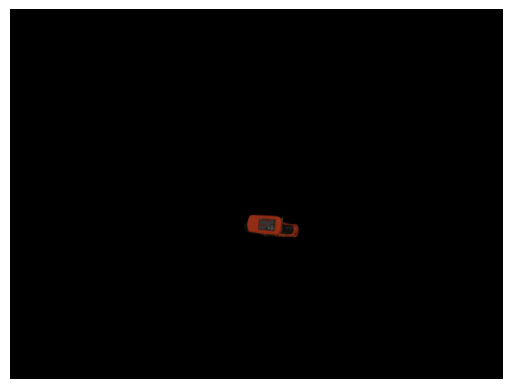

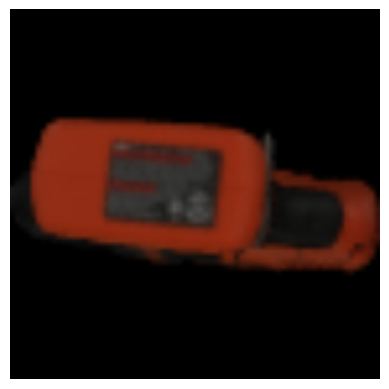

In [15]:
# sanity check the renderings
plt.imshow(rgb)
plt.axis('off')
plt.show()

plt.imshow(rgb_local)
plt.axis('off')
plt.show()

## Now train the model, you may train for more epochs if you have more objects in the category.

In [2]:
class ExportDataset(torch.utils.data.Dataset):
    def __init__(self, root):
        super().__init__()
        self.data = list(sorted(Path(root).glob('*.pkl')))
            
    def __getitem__(self, idx):
        if idx >= len(self):
            raise IndexError("Index out of bounds")
        data = pickle.load(open(self.data[idx], 'rb'))
        return data

    def __len__(self):
        return len(self.data)

In [5]:
from train_shot import BeyondCPPF as BeyondCPPFSHOT
from train_dino import BeyondCPPF as BeyondCPPFDINO
from pytorch_lightning.callbacks import ModelCheckpoint
from time import time
from multiprocessing import cpu_count
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger

model_ckpt = ModelCheckpoint(save_last=True, save_top_k=-1, every_n_epochs=10, filename='{epoch}')
shot_module = BeyondCPPFSHOT(cfg)
logger = TensorBoardLogger(save_dir='logs', name='shot')
trainer = pl.Trainer(max_epochs=11, logger=logger, accelerator='auto', callbacks=[model_ckpt], detect_anomaly=False)

def init_fn(i):
    return np.random.seed(round(time() * 1000) % (2 ** 32) +  i)

ds = ExportDataset('data/demo_data')
df = torch.utils.data.DataLoader(ds, pin_memory=True, batch_size=1, shuffle=True, num_workers=cpu_count() // 2, worker_init_fn=init_fn)

trainer.fit(shot_module, df)

ModelCheckpoint(save_last=True, save_top_k=-1, monitor=None) will duplicate the last checkpoint saved.
/orion/u/yangyou/miniconda3/envs/py39/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /orion/u/yangyou/miniconda3/envs/py39/lib/python3.9/ ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/orion/u/yangyou/miniconda3/envs/py39/lib/python3.9/site-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 48 worker processes in total. Our suggested max number of worker in current system is 10, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get

Training: 0it [00:00, ?it/s]

/orion/u/yangyou/miniconda3/envs/py39/lib/python3.9/site-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 48 worker processes in total. Our suggested max number of worker in current system is 10, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
`Trainer.fit` stopped: `max_epochs=11` reached.


In [6]:
model_ckpt = ModelCheckpoint(save_last=True, save_top_k=-1, every_n_epochs=10, filename='{epoch}')
dino_module = BeyondCPPFDINO(cfg)
logger = TensorBoardLogger(save_dir='logs', name='dino')
trainer = pl.Trainer(max_epochs=11, logger=logger, accelerator='auto', callbacks=[model_ckpt], detect_anomaly=False)

trainer.fit(dino_module, df)

/orion/u/yangyou/miniconda3/envs/py39/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /orion/u/yangyou/miniconda3/envs/py39/lib/python3.9/ ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A5000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Missing logger folder: logs/dino
/orion/u/yangyou/miniconda3/envs/py39/lib/python3.9/site-packages

Training: 0it [00:00, ?it/s]

/orion/u/yangyou/miniconda3/envs/py39/lib/python3.9/site-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 48 worker processes in total. Our suggested max number of worker in current system is 10, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/orion/u/yangyou/miniconda3/envs/py39/lib/python3.9/site-packages/pytorch_lightning/callbacks/progress/base.py:249: UserWarning: The progress bar already tracks a metric with the name(s) 'loss' and `self.log('loss', ..., prog_bar=True)` will overwrite this value.  If this is undesired, change the name or override `get_metrics()` in the progress bar callback.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=11` reached.


## Let's do Sim-to-Real tranfer and test on real-world images!

In [2]:
import torch_scatter
from utils.util import downsample, backproject, fibonacci_sphere, calculate_2d_projections, draw, get_3d_bbox, transform_coordinates_3d
from train_dino import vote_center, vote_rotation, generate_target_pairs
from demo import get_topk_dir
import torch.optim as optim
angle_tol=1.
imp_wt_margin=0.01
backproj_ratio=.1
num_pairs=50000
num_rots=180
opt=True


num_samples = int(4 * np.pi / (angle_tol / 180 * np.pi))
sphere_pts = np.array(fibonacci_sphere(num_samples), dtype=np.float32)
bmm_size = 100000

# replace this with your own camera intrinsic
intrinsics = np.array([1066.778, 0.0, 312.9869, 0.0, 1067.487, 241.3109, 0.0, 0.0, 1.0]).reshape(3, 3)

In [5]:
from train_shot import BeyondCPPF as BeyondCPPFSHOT
from train_dino import BeyondCPPF as BeyondCPPFDINO
from pytorch_lightning.callbacks import ModelCheckpoint
from time import time
from multiprocessing import cpu_count
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger

cfg = OmegaConf.load('config/custom.yaml')
dino_model = BeyondCPPFDINO.load_from_checkpoint('logs/dino/version_0/checkpoints/last.ckpt', cfg=cfg).cuda().eval()
shot_model = BeyondCPPFSHOT.load_from_checkpoint('logs/shot/version_0/checkpoints/last.ckpt', cfg=cfg).cuda().eval()

Using cache found in /orion/u/yangyou/hub/facebookresearch_dinov2_main
/orion/u/yangyou/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/orion/u/yangyou/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/orion/u/yangyou/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


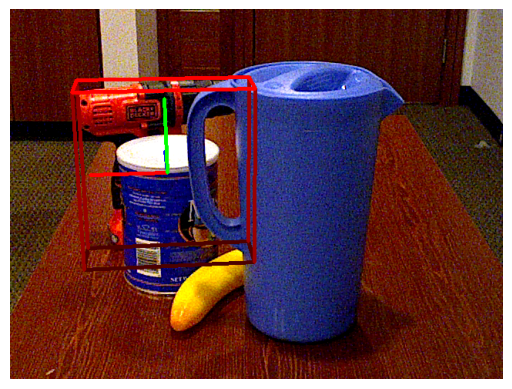

In [6]:
desc_model = DINOV2().eval().cuda()
with torch.no_grad():
    rgb = cv2.imread('/orion/u/yangyou/cppf/data/ycbv/test/000056/rgb/000005.png')[..., ::-1]
    depth = cv2.imread('/orion/u/yangyou/cppf/data/ycbv/test/000056/depth/000005.png', cv2.IMREAD_UNCHANGED).astype(np.float32) / 10000.  # caution: scale may be different for your depth image
    draw_image_bbox = rgb.copy()

    mask = cv2.imread('/orion/u/yangyou/cppf/data/ycbv/test/000056/mask_visib/000005_000003.png', cv2.IMREAD_UNCHANGED).astype(bool)
    rgb_masked = np.zeros_like(rgb)
    rgb_masked[mask] = rgb[mask]
    rgb_local, transform = resize_crop(rgb_masked, bbox=Image.fromarray(rgb_masked).getbbox(), padding=0, out_size=256)

    pc, idxs = backproject(depth, intrinsics, mask)
    idxs = np.stack(idxs, -1)  # K x 2
    pc[:, 0] = -pc[:, 0]
    pc[:, 1] = -pc[:, 1]
    pc = pc.astype(np.float32)
    indices = downsample(pc, cfg.res)
    pc = pc[indices]
    idxs = idxs[indices]
    if pc.shape[0] > 50000:
        sub_idx = np.random.randint(pc.shape[0], size=(50000,))
        pc = pc[sub_idx]
        idxs = idxs[sub_idx]

    kp = np.flip(idxs, -1)
    kp_local = (np.linalg.inv(transform) @ np.concatenate([kp, np.ones((kp.shape[0], 1))], -1).T).T[:, :2]

    desc = desc_model(torch.from_numpy(rgb_local).cuda().float().permute(2, 0, 1) / 255., torch.from_numpy(kp_local).float().cuda()).cpu().numpy()

    point_idxs_all = np.random.randint(0, pc.shape[0], (num_pairs, 2 + cfg.num_more))
    input_pairs = pc[point_idxs_all[:, :2]]

    shot_feat, normal = shot.compute(pc, cfg.res * 10, cfg.res * 10)
    shot_feat = shot_feat.reshape(-1, 352).astype(np.float32)
    # shot_feat = np.zeros((pc.shape[0], 352), dtype=np.float32)

    normal = normal.reshape(-1, 3).astype(np.float32)
    shot_feat[np.isnan(shot_feat)] = 0
    normal[np.isnan(normal)] = 0

    best_loss, best_idx = np.inf, 0
    best_RT = np.eye(4)
    best_scale = np.zeros((3,))
    for model_idx, model in enumerate([dino_model, shot_model]):
        if model_idx == 0:
            pred_cls, pred_scales = model(torch.from_numpy(pc).float().cuda(), torch.from_numpy(desc).float().cuda(), torch.from_numpy(point_idxs_all).long().cuda())
        else:
            pred_cls, pred_scales = model(torch.from_numpy(pc).float().cuda(), torch.from_numpy(point_idxs_all).long().cuda(),
                                        torch.from_numpy(shot_feat).float().cuda(), torch.from_numpy(normal).float().cuda())
        pred_pairs = pred_cls.reshape(pred_cls.shape[0], 2, 3, -1)
        num_bins = pred_cls.shape[-1]
        prob = torch.softmax(pred_cls, -1)

        pred_pairs = torch.multinomial(prob.reshape(np.product(pred_cls.shape[:-1]), -1), 1).float().reshape(-1, 2, 3)
        pred_pairs = (pred_pairs / (num_bins - 1) - 0.5)
        # pred_pairs = (prob2real(prob, 1., prob.shape[-1]) - 0.5).reshape(-1, 2, 3)  # this line gives worse results, just do multinomial by treating it as a sampling rather than expectation
        
        scale = torch.from_numpy(np.linalg.norm(input_pairs[:, 1] - input_pairs[:, 0], axis=-1)).float().cuda() \
            / torch.clamp_min(torch.norm(pred_pairs[:, 1] - pred_pairs[:, 0], dim=-1), 1e-7)
        pred_pairs_scaled = pred_pairs * scale[:, None, None]
        
        targets_tr, targets_rot = generate_target_pairs(pred_pairs_scaled.cpu().numpy(), 
                                                        np.array(cfg.up),
                                                        np.array(cfg.front),
                                                        np.array(cfg.right))
        grid_obj, pred_trans = vote_center(torch.from_numpy(pc).float().cuda(), 
            torch.from_numpy(targets_tr).float().cuda(), 
            cfg.res, 
            torch.from_numpy(point_idxs_all[:, :2]).long().cuda(),
            num_rots=num_rots, 
            vis=None)
        
        # if model_idx == 0:
        T_est = pred_trans
        
        # backvoting
        targets_tr_back, _ = generate_target_pairs(input_pairs, 
                                                        np.array(cfg.up),
                                                        np.array(cfg.front),
                                                        np.array(cfg.right),
                                                        T_est)
        back_errs = np.linalg.norm(targets_tr - targets_tr_back, axis=-1)
        pairs_mask = back_errs < np.percentile(back_errs, backproj_ratio * 100)
        # pairs_mask = back_errs < backproj_thres
        # print(pairs_mask.sum() / point_idxs_all.shape[0])
        point_idxs_pair_flattened = point_idxs_all[pairs_mask, :2].reshape(-1)
        unique_idx = np.unique(point_idxs_pair_flattened)
        pc_masked = pc[unique_idx]
        point_idxs_pair_flattened = torch.from_numpy(point_idxs_pair_flattened).cuda().long()
        imp_wt = torch_scatter.scatter_add(torch.ones_like(point_idxs_pair_flattened), 
                                        point_idxs_pair_flattened, dim=-1, dim_size=pc.shape[0]).cpu().numpy()

        
        point_idxs_all_filtered = point_idxs_all[pairs_mask]
        targets_rot = targets_rot[pairs_mask]
        scale = scale[pairs_mask]
        pred_scales = pred_scales[pairs_mask]
        
        imp_wt = imp_wt / imp_wt.max()
        imp_pair_wt = torch.from_numpy(imp_wt[point_idxs_all_filtered[:, :2]]).cuda().sum(-1) + imp_wt_margin  # N
        # imp_pair_wt.fill_(1.)
        preds_up, valid_mask = vote_rotation(torch.from_numpy(pc).float().cuda(),
            torch.from_numpy(targets_rot[..., 0]).float().cuda(),
            torch.from_numpy(point_idxs_all_filtered[:, :2]).long().cuda(),
            num_rots)
        preds_up = preds_up.reshape(-1, 3)
        preds_ups, cnts = get_topk_dir(preds_up, sphere_pts, bmm_size, angle_tol, 
                                imp_pair_wt[valid_mask, None].expand(-1, num_rots).reshape(-1, 1), topk=1)
        preds_up = preds_ups[0]
        
        preds_right, valid_mask = vote_rotation(torch.from_numpy(pc).float().cuda(),
            torch.from_numpy(targets_rot[..., 2]).float().cuda(),
            torch.from_numpy(point_idxs_all_filtered[:, :2]).long().cuda(),
            num_rots)
        preds_right = preds_right.reshape(-1, 3)
        preds_rights, cnts = get_topk_dir(preds_right, sphere_pts, bmm_size, angle_tol,
                                imp_pair_wt[valid_mask, None].expand(-1, num_rots).reshape(-1, 1), topk=1)
        preds_right = preds_rights[0]
        
        preds_right -= np.dot(preds_up, preds_right) * preds_up
        preds_right /= (np.linalg.norm(preds_right) + 1e-9)
        
        up_loc = np.where(cfg.up)[0][0]
        right_loc = np.where(cfg.right)[0][0]
        R_est = np.eye(3)
        R_est[:3, up_loc] = preds_up
        R_est[:3, right_loc] = preds_right
        
        if model_idx == 0:
            pred_scale = torch.median(pred_scales, 0)[0].cpu().numpy()
            pred_scale_norm = np.linalg.norm(pred_scale)

        other_loc = list(set([0, 1, 2]) - set([up_loc, right_loc]))[0]
        R_est[:3, other_loc] = np.cross(R_est[:3, (other_loc + 1) % 3], R_est[:3, (other_loc + 2) % 3])
        if opt:
            from lietorch import SO3
            with torch.enable_grad():
                opt_trans = torch.nn.Parameter(torch.from_numpy(T_est).cuda().float(), requires_grad=True)
                delta_rot = torch.tensor([0, 0, 0, 1.], requires_grad=True, device='cuda')
                pc_cuda = torch.from_numpy(pc).float().cuda()
                opt = optim.Adam([opt_trans, delta_rot], lr=1e-2)
                # tq = tqdm(range(100))
                for _ in range(100):
                    opt.zero_grad()
                    rot = SO3.InitFromVec(delta_rot).matrix()[:3, :3] @ torch.from_numpy(R_est).float().cuda()
                    pc_canon = (pc_cuda - opt_trans) @ rot
                    loss = torch.abs(pc_canon[point_idxs_all_filtered[:, :2]] - pred_pairs_scaled[pairs_mask])
                    loss = loss.mean()
                    loss.backward()
                    # opt_trans.grad = opt_trans.grad * 1e-2
                    delta_rot.grad = delta_rot.grad / 180 * np.pi
                    opt.step()
                    # tq.set_description(f'loss: {loss.item():.4f}')
            
            T_est = opt_trans.detach().cpu().numpy()
            R_est = (SO3.InitFromVec(delta_rot).matrix()[:3, :3] @ torch.from_numpy(R_est).float().cuda()).detach().cpu().numpy()
            
        
        pc_canon = (pc - T_est) @ R_est / pred_scale_norm
        loss = np.abs(pc_canon[point_idxs_all_filtered[:, :2]] - pred_pairs[pairs_mask].cpu().numpy())
        loss = np.clip(loss, 0, 0.1)
        loss = loss.mean()
        
        if loss < best_loss:
            best_loss = loss
            best_idx = model_idx
            best_RT[:3, :3] = R_est * pred_scale_norm
            best_RT[:3, -1] = T_est
            best_scale = pred_scale / pred_scale_norm

    xyz_axis = 0.3 * np.array([[0, 0, 0], [0, 0, 1], [0, 1, 0], [1, 0, 0]]).transpose()
    transformed_axes = transform_coordinates_3d(xyz_axis, best_RT)
    projected_axes = calculate_2d_projections(transformed_axes, intrinsics)

    bbox_3d = get_3d_bbox(best_scale, 0)
    transformed_bbox_3d = transform_coordinates_3d(bbox_3d, best_RT)
    projected_bbox = calculate_2d_projections(transformed_bbox_3d, intrinsics)
    draw_image_bbox = draw(draw_image_bbox, projected_bbox, projected_axes, (255, 0, 0))
    plt.imshow(draw_image_bbox)
    plt.axis('off')
    plt.show()

### DONE! Our method is robust. even trained without occlusion, it can generalize to real-world challenging scenarios.

### This tutorial shows how you can train a custom object. You can expand to a custom category easily and our model handles both instance and category level pose estimations, robustly!